Import dependencies

In [1]:
from model.layers import GraphSpectralFilterLayer, AnalysisFilter
from model.spectral_filter import Graph
import torch
import torch.nn.functional as F
from torch import nn
from random import seed as rseed
from numpy.random import seed as nseed
from citation import get_dataset, random_planetoid_splits, run
from citation.train_eval import evaluate
import numpy as np


Define hyperparameters

In [2]:
dataset_name = 'CiteSeer'

random_splits = False
runs = 1
epochs =400
alpha = 0.7709619178612326
seed =729
lr =0.00022455151763075903
weight_decay = 7.530100210192558e-05
patience=100
hidden=32
heads =14
dropout=0.6174883141474811
normalize_features =True
pre_training = False
cuda = False
chebyshev_order =15
edge_dropout =0
node_feature_dropout =0
filter_name ='analysis'

rseed(seed)
nseed(seed)
torch.manual_seed(seed)

Define model

In [3]:
class Net(torch.nn.Module):
    def __init__(self, dataset):
        super(Net, self).__init__()
        data = dataset[0]
        adj = torch.sparse_coo_tensor(data.edge_index, torch.ones(data.num_edges))
        self.G = Graph(adj)
        self.G.estimate_lmax()

        self.analysis = GraphSpectralFilterLayer(self.G, dataset.num_node_features, hidden,
                                                 dropout=dropout, out_channels=heads, filter=filter_name,
                                                 pre_training=pre_training, device='cuda' if cuda else 'cpu',
                                                 alpha=alpha, chebyshev_order=chebyshev_order)

        self.synthesis = GraphSpectralFilterLayer(self.G, hidden * heads, dataset.num_classes, filter=filter_name,
                                                  device='cuda' if cuda else 'cpu', dropout=dropout,
                                                  out_channels=1, alpha=alpha, pre_training=False,
                                                  chebyshev_order=chebyshev_order)

    def reset_parameters(self):
        self.analysis.reset_parameters()
        self.synthesis.reset_parameters()

    def forward(self, data):
        x = data.x
        x = F.dropout(x, p=dropout, training=self.training)
        x, attentions_1 = self.analysis(x)
        x = F.dropout(x, p=dropout, training=self.training)
        x, attentions_2 = self.synthesis(x)
        x = F.elu(x)
        return F.log_softmax(x, dim=1), attentions_1, attentions_2


dataset = get_dataset(dataset_name, normalize_features, edge_dropout=edge_dropout,
                                node_feature_dropout=node_feature_dropout)

if cuda:
    dataset[0].to('cuda')

Load trained model and evaluate

In [4]:
model = Net(dataset)
model.load_state_dict(torch.load('./model/best_Citeseer_lt_zero.pkl'.format(dataset_name),  map_location={'cuda:0': 'cpu'}))
filter_kernel = model.analysis.filter_kernel

eval_info = evaluate(model, dataset[0])
print(eval_info)

{'train_loss': 0.3670344054698944, 'train_acc': 0.9211822660098522, 'train_micro_f1': 0.9211822660098522, 'train_macro_f1': 0.9157023986911743, 'val_loss': 0.6948288679122925, 'val_acc': 0.796, 'val_micro_f1': 0.796, 'val_macro_f1': 0.7447925714273606, 'test_loss': 0.694846510887146, 'test_acc': 0.805, 'test_micro_f1': 0.805, 'test_macro_f1': 0.7737372300784445}


Obtain attention weights in layer 1 and 2

In [5]:
with torch.no_grad():
    _, att1, att2 = model(dataset[0])
model_att1_sum = torch.stack(att1).sum(dim=0)

Build NetworkX Graph

In [6]:
import networkx as nx
from scipy.sparse import coo_matrix
import numpy as np

# Build graph
adj = coo_matrix(
    (np.ones(dataset[0].num_edges),
    (dataset[0].edge_index[0].numpy(), dataset[0].edge_index[1].numpy())),
    shape=(dataset[0].num_nodes, dataset[0].num_nodes))
G = nx.Graph(adj)


In [7]:
from matplotlib import pyplot as plt
def plot_filter_banks(idx=list(range(heads)), kernel=model.analysis.filter._kernel, ax=None, no_ticks=False, legend=True):
    x = torch.linspace(0, 2, 100)
    if not ax:
        plt.figure(figsize=(5,5))
        plt.plot(x, kernel(x).detach()[:, idx], linewidth=15)
#         if len(idx) > 1 and legend:
#             plt.legend(['filter {}'.format(i) for i in range(1, len(idx) + 1)])
#         plt.show()
    else:
        ax.plot(x, kernel(x).detach()[:, idx])
#         if len(idx) > 1 and legend:
#             ax.legend(['filter {}'.format(i) for i in range(1, len(idx) + 1)])
    if no_ticks:
        plt.xticks([])
        plt.yticks([])
    else:
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)


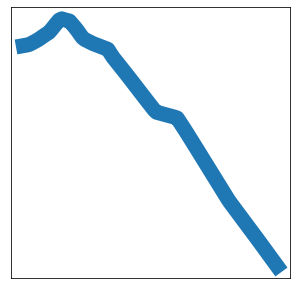

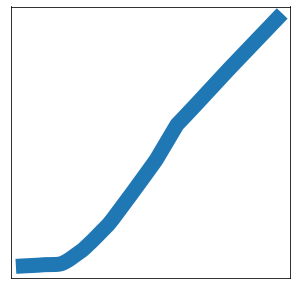

In [8]:
for i in [10, 5]:
    plot_filter_banks(idx=[i], kernel=model.analysis.filter._kernel, legend=False, no_ticks=True)
    plt.savefig('./node_269_filter_{}.svg'.format(str(i)), format='svg', dpi=450)

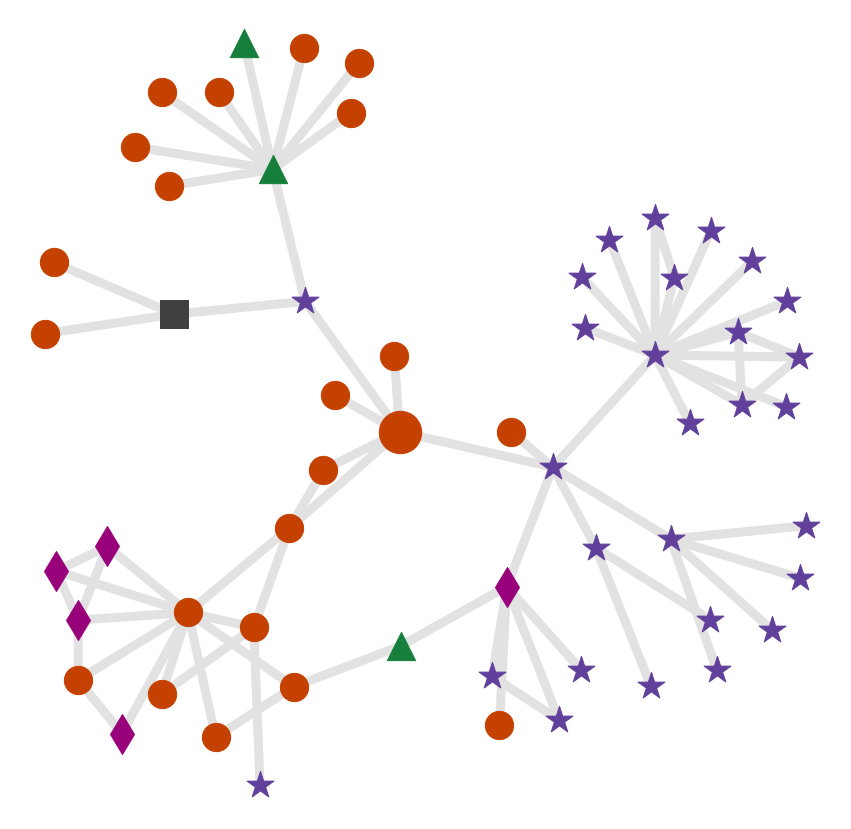

In [9]:
node = 269
Gego = nx.ego_graph(G, node, 3)
nodePos = nx.layout.kamada_kawai_layout(Gego)

node_colors = {
   0: plt.cm.Reds, 1: plt.cm.Oranges, 2: plt.cm.RdPu, 
   3: plt.cm.Greens, 4: plt.cm.Greys, 5: plt.cm.Purples, 
}
node_shapes={0: '8', 1: 'o', 2: 'd', 3: '^', 4: 's', 5: '*'}



plt.figure(figsize=(15,15))

for n in Gego.nodes:
    nx.draw_networkx_nodes(Gego, nodePos,
                           nodelist=[n],
                           node_color=[node_colors[dataset[0].y[n].item()](0.8)],
                           node_shape=node_shapes[dataset[0].y[n].item()],
                           node_size=1800 if n == node else 800,)
nx.draw_networkx_edges(Gego, nodePos,
#                            edgelist=[*[(node, n) for n in nodes], ],
                           edgelist= Gego.edges,
#                            width=[5 if e in edges else 2 for e in Gego.edges],
                           width=9,
#                            edge_color=[plt.cm.Greys(0.8) if e in edges else plt.cm.Greys(0.2) for e in Gego.edges],
                           edge_color=plt.cm.Greys(0.2))
plt.box(on=None)
# plt.savefig('./node_269_ego.svg', format='svg', dpi=450)
# plt.clf()
plt.show()


0 16


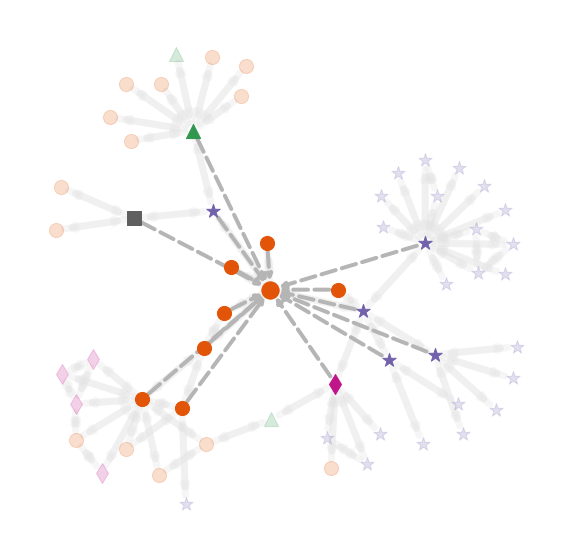

10 7


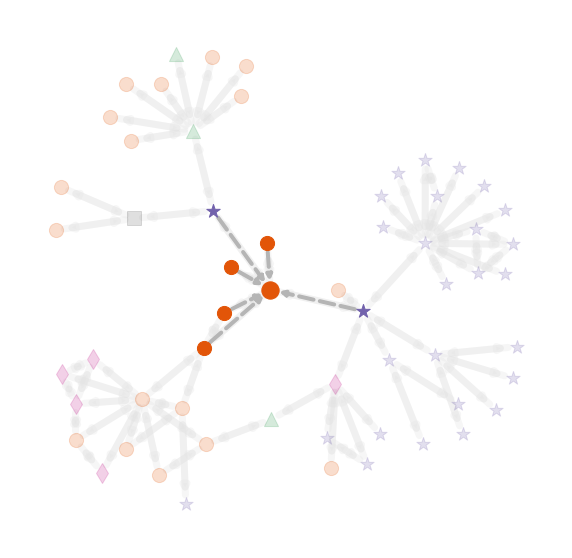

In [22]:
node=269
for i in [0, 10]:
    plt.figure(figsize=(10,10))
    plt.box(on=None)
    att = att1[i]
    nodes = (att[node] > 0.0).nonzero().view(-1).tolist()
    print(i, len(nodes))
    for n in Gego.nodes:
        nx.draw_networkx_nodes(Gego, nodePos,
                               nodelist=[n],
                               node_color=[node_colors[dataset[0].y[n].item()](0.7)],
                               node_shape=node_shapes[dataset[0].y[n].item()],
#                                node_size=(att1[i][node, n]*8000).clamp(max=1000).item(),
                               alpha=1 if n in nodes else 0.2,
                               node_size=300 if n == node else 200
                              )
    
    edges = list(filter(lambda e: e[0] in nodes and e[1] in nodes, list(Gego.edges)))
    nx.draw_networkx_edges(Gego, nodePos,
#                            edgelist=[*[(node, n) for n in nodes], ],
                           edgelist= Gego.edges,
#                            width=[5 if e in edges else 2 for e in Gego.edges],
                           width=7,
#                            edge_color=[plt.cm.Greys(0.8) if e in edges else plt.cm.Greys(0.2) for e in Gego.edges],
                           edge_color=plt.cm.Greys(0.2),
                           alpha=0.3)
    nx.draw_networkx_edges(Gego, nodePos,
                           edgelist=[*[(n, node) for n in nodes], ],
#                            edgelist= Gego.edges,
#                            width=[5 if e in edges else 2 for e in Gego.edges],
                           width=4,
                           style="dashed",
#                            edge_color=[plt.cm.Greys(0.8) if e in edges else plt.cm.Greys(0.2) for e in Gego.edges],
#                            alpha=0.5,
                           edge_color=plt.cm.Greys(0.4),
                           arrows=True)
    plt.show()
#     plt.savefig('./node_269_ego_{}.svg'.format(str(i)), format='svg', dpi=450)
#     plt.clf()


0 16


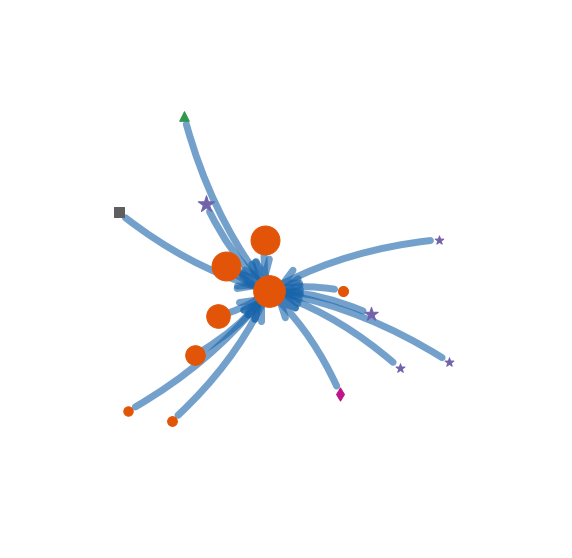

10 7


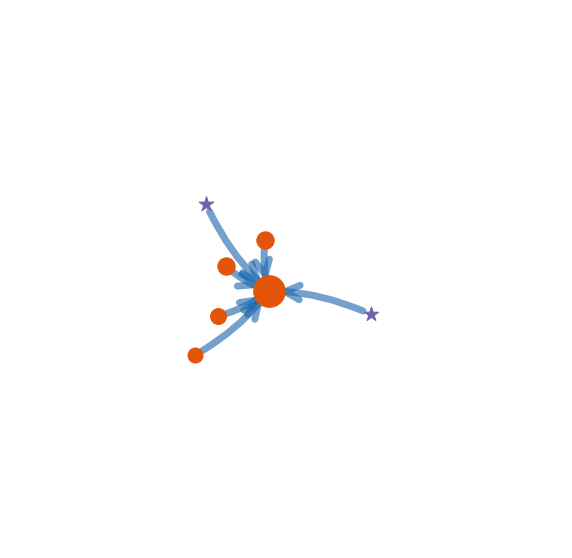

In [21]:
node=269
for i in [0, 10]:
    plt.figure(figsize=(10,10))
    plt.box(on=None)
    att = att1[i]
    nodes = (att[node] > 0.0).nonzero().view(-1).tolist()
    print(i, len(nodes))
    for n in Gego.nodes:
#     for n in nodes:
        nx.draw_networkx_nodes(Gego, nodePos,
                               nodelist=[n],
                               node_color=[node_colors[dataset[0].y[n].item()](0.7)],
                               node_shape=node_shapes[dataset[0].y[n].item()],
                               node_size=(att1[i][node, n]*8000).clamp(max=1000).item(),
                               alpha=1 if n in nodes else 0.2
#                                node_size=300 if n == node else (torch.exp(att[node, n])*100).clamp(max=300, min=50),
#                                node_size=300 if n == node else 200
                              )
    
    edges = list(filter(lambda e: e[0] in nodes and e[1] in nodes, list(Gego.edges)))
    Gego = nx.DiGraph(Gego)
    nx.draw_networkx_edges(Gego, nodePos,
                           edgelist=[*[(n, node) for n in nodes], ],
#                            edgelist= Gego.edges,
#                            width=[5 if e in edges else 2 for e in Gego.edges],
                           width=7,
#                            edge_color=[plt.cm.Greys(0.8) if e in edges else plt.cm.Greys(0.2) for e in Gego.edges],
                           alpha=0.6,
                           arrowsize=36,
                           arrowstyle='->',
                           edge_color=plt.cm.Blues(0.8),
                           connectionstyle='arc3,rad=0.1',
                           arrows=True)
    plt.show()
#     plt.savefig('./node_269_ego_{}.svg'.format(str(i)), format='svg', dpi=450)
#     plt.clf()
